In [2]:
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from collections import defaultdict
import math

In [3]:
with open('../data/ddg.json') as file:
    file_contents = file.read()
    ddg_dict = json.loads(file_contents)

with open('../data/ddg_err.json') as file:
    file_contents = file.read()
    ddg_err_dict = json.loads(file_contents)

with open('../data/ddg_half.json') as file:
    file_contents = file.read()
    ddg_dict_half = json.loads(file_contents)

with open('../data/ddg_err_half.json') as file:
    file_contents = file.read()
    ddg_err_dict_half = json.loads(file_contents)

In [4]:
ddg_sum = defaultdict()
dg_err_vac_sum = defaultdict()
dg_err_wat_sum = defaultdict()
ddg_err_sum = defaultdict()
conv_vac_sum = defaultdict()
conv_wat_sum = defaultdict()

for key, value in ddg_dict.items():
    if key[-3] not in ddg_sum:
        ddg_sum[key[-3]] = {'0': {}, '1': {}, '2': {}}
    if "B" in key.split("_")[-1]:
        ddg_sum[key[-3]]['0']['P'] = value
        ddg_sum[key[-3]]['0']['Abbrev_P'] = f'{key[-3]}PA->{key[-3]}PB'

for key, value in ddg_dict_half.items():
    if 'I' not in ddg_sum[key[-3]][key[-1]]:
        if key[-5] == "A":
            ddg_sum[key[-3]][key[-1]]['I'] = value
        else:
            ddg_sum[key[-3]][key[-1]]['I'] = -value
    else:
        if key[-5] == "A":
            ddg_sum[key[-3]][key[-1]]['I'] += value
        else:
            ddg_sum[key[-3]][key[-1]]['I'] += -value
    ddg_sum[key[-3]][str(
        int(key[-1])
    )]['Abbrev_I'] = f'{key[-3]}I{str(int(key[-1]))}'

for key, value in ddg_err_dict.items():
    if key[-3] not in ddg_err_sum:
        ddg_err_sum[key[-3]] = {'0':{}, '1':{}, '2':{}}
    if "B" in key.split("_")[-1]:
        ddg_err_sum[key[-3]]['0']['P'] = value

for key, value in ddg_err_dict_half.items():
    if 'I' not in ddg_err_sum[key[-3]][key[-1]]:
        ddg_err_sum[key[-3]][key[-1]]['I'] = value
    else:
        ddg_err_sum[key[-3]][key[-1]]['I'] = math.sqrt(ddg_err_sum[key[-3]][key[-1]]['I']**2 + value**2)


In [5]:
df_ddg = pd.DataFrame.from_dict({(i,j): ddg_sum[i][j] 
                           for i in ddg_sum.keys() 
                           for j in ddg_sum[i].keys()},
                       orient='index')

df_ddg_err = pd.DataFrame.from_dict({(i,j): ddg_err_sum[i][j] 
                           for i in ddg_sum.keys() 
                           for j in ddg_sum[i].keys()},
                       orient='index').add_suffix('_std')

In [6]:
df = df_ddg.join([df_ddg_err])

In [7]:
np.array([float(x) for x in df.loc(axis=0)[:, str(0)].index.get_level_values(0)])

array([1., 2., 3., 4., 5., 6., 7.])

In [8]:
np.arange(float(max(df.index)[0])) 

array([0., 1., 2., 3., 4., 5., 6.])

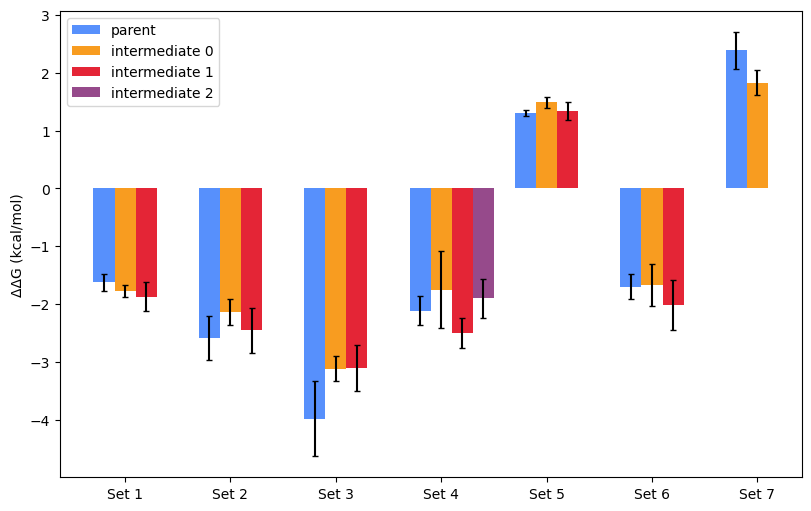

In [12]:
fig, ax = plt.subplots(layout='constrained', figsize=(8,5))

x = np.arange(float(max(df.index)[0]))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0
colors = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]

for i, (values, stds) in enumerate([('P', 'P_std'), ('I', 'I_std'), ('I', 'I_std'), ('I', 'I_std')]):
    n = i
    if values == "I":
        n = i - 1
    offset = width * multiplier
    x = np.array([float(x) for x in df.loc(axis=0)[:, str(n)].index.get_level_values(0)])
    rects = ax.bar(x + offset, df.loc(axis=0)[:, str(n)][values].values, width, yerr=df.loc(axis=0)[:, str(n)][stds].values, label=values, capsize=2, color=colors[i])
    # ax.bar_label(rects, padding=3)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ΔΔG (kcal/mol)')
x = np.arange(1, float(max(df.index)[0])+1) 
ax.set_xticks(x + width, [f'Set {str(int(y))}' for y in x])#, ['LOMAP', 'ROCS', "Tanimoto"])
ax.legend(loc='upper left', labels=["parent", "intermediate 0", "intermediate 1", "intermediate 2"])
# ax.set_ylim(0, 1)
# ax.set_xticks([])

plt.show()